In [85]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import keras_ocr

In [86]:
def get_metadata(ID):
    metadata = pd.read_csv(os.path.join('inputs\metadata', ID +'.csv'))
    return metadata

## get scale

In [87]:
def get_scale(ID, metadata):

    scale_image = Image.open(os.path.join('inputs\scales', ID +'.png'))
    scale = np.array(scale_image)
    scale = scale[:,0,:3]

    su = metadata[metadata['Dim'] == 'SU']['z'].values[0]
    sl = metadata[metadata['Dim'] == 'SL']['z'].values[0]
    scale_range = su - sl

    scale_items = scale.shape[0]
    scale_fidelity = scale_range / scale_items
    z_values = np.arange(1, scale_items + 1) * scale_fidelity
    z_values_df = pd.DataFrame(z_values, columns=['z'])
    scale_df = pd.DataFrame(scale, columns=['r', 'g', 'b'])
    scale_df = scale_df.join(z_values_df)
    scale_df = (scale_df.groupby(['r','g','b']).agg(z_mean=('z', 'mean'))).reset_index()
    scale = scale_df.to_numpy()

    return scale

## get efficiency map

#### infill text
- read cropped efficiency map image 
- use a bounding box ocr to identify text
- inpaint these regions

In [88]:
# infill text using ocr

def infill_text(ID):

    def midpoint(x1, y1, x2, y2):
        x_mid = int((x1 + x2)/2)
        y_mid = int((y1 + y2)/2)
        return (x_mid, y_mid)

    pipeline = keras_ocr.pipeline.Pipeline()

    img = keras_ocr.tools.read(os.path.join('inputs\efficiency_maps', ID +'.png'))

    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                    
    return(img)

#### infill lines and egdes
- convert image output to grayscale
- Use Canny edge detection to identify edges
- inpaint these extended by a region

In [89]:
def infill_lines(im):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150)

    # Create a mask by dilating the edges
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(edges, kernel, iterations=1)

    nolines = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

    return nolines

#### infill black
- convert image to grayscale
- infill black

In [107]:
def infill_black(im):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    black = [0,1,2,3,4] # these are black and close to black

    mask = np.ones_like(gray) * 255  # Initialize mask with all white pixels
    for value in black:
        mask[gray == value] = 0  # Set pixels with predefined grayscale values to black in the mask

    noblack = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return noblack

In [78]:
#scale[:,:3]

## main

In [91]:
ID = 'HDSRM300'
#ID = 'YASA_P400'
#ID = '180-100-009'

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 4s 4s/step


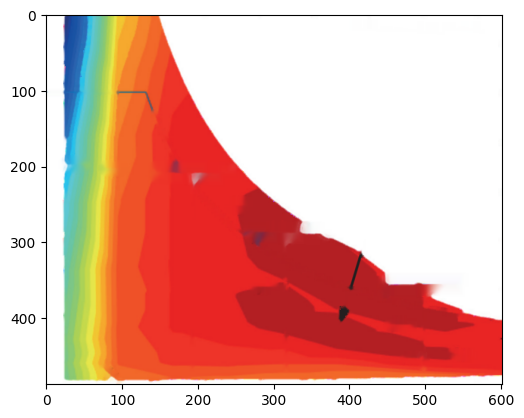

In [109]:
metadata = get_metadata(ID)
scale = get_scale(ID, metadata)
em = infill_text(ID)
plt.imshow(em)
nolines = infill_lines(em)
plt.imshow(nolines)
noblack = infill_black(nolines)
plt.imshow(noblack)

In [122]:
def preprocess(ID):
    metadata = get_metadata(ID)
    scale = get_scale(ID, metadata)
    em = infill_text(ID)
    nolines = infill_lines(em)
    processed_img = infill_black(nolines)

    return processed_img

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 4s 4s/step


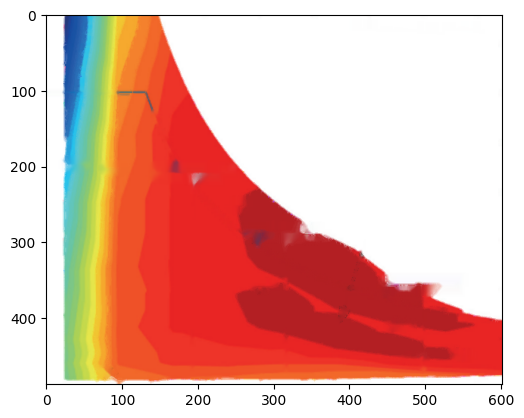

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 3s 3s/step


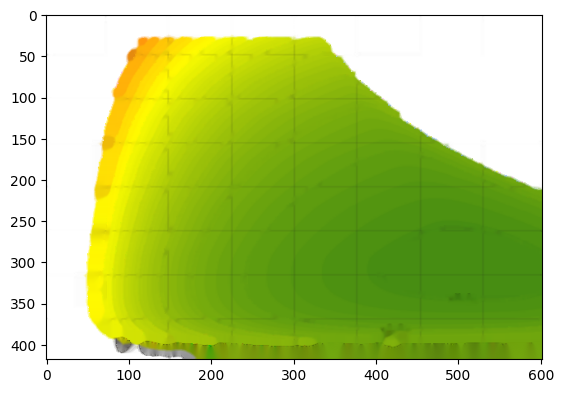

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 4s 4s/step


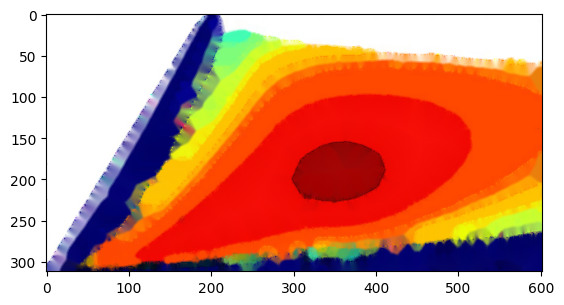

In [124]:
IDS = ['HDSRM300', 'YASA_P400', '180-100-009']
for ID in IDS:
    plt.show()
    processed_img = preprocess(ID)
    plt.imshow(processed_img)

In [27]:
im = cv2.cvtColor(inscale, cv2.COLOR_BGR2GRAY)

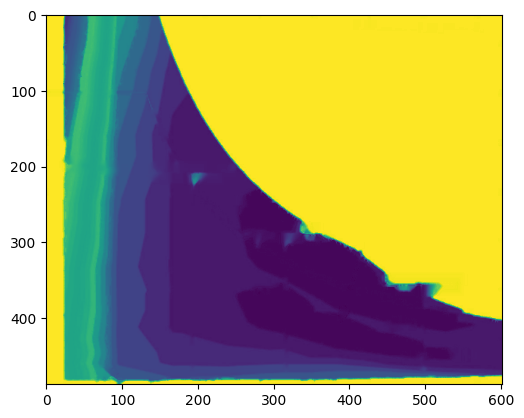

In [28]:
plt.imshow(im)

In [29]:
im.shape

(488, 602)

In [30]:
im[200][200]

61

In [32]:
im.shape[1]

602

In [58]:
x_rl = metadata[metadata['Dim'] == 'RL']['x'].values[0]
x_ll = metadata[metadata['Dim'] == 'LL']['x'].values[0]
max_xi = im.shape[1] - 1

y_lu = metadata[metadata['Dim'] == 'LU']['y'].values[0]
y_ll = metadata[metadata['Dim'] == 'LL']['y'].values[0]
max_yi = im.shape[0] - 1


In [59]:
x = []
y = []
for xi in range(0, im.shape[1]):
    xbar = ((x_rl - x_ll) * xi) / max_xi
    x.append(xbar)
for yi in range(0, im.shape[0]):
    ybar = ((y_lu - y_ll) * (max_yi - yi)) / max_yi
    y.append(ybar)  

In [64]:
su

0.97

In [65]:
sl

0.7

In [66]:
scale

[46,
 45,
 49,
 54,
 55,
 56,
 60,
 62,
 63,
 64,
 67,
 68,
 70,
 71,
 74,
 75,
 76,
 79,
 80,
 81,
 82,
 83,
 87,
 89,
 88,
 92,
 95,
 96,
 99,
 101,
 103,
 102,
 104,
 106,
 108,
 109,
 110,
 111,
 112,
 115,
 117,
 119,
 118,
 121,
 122,
 124,
 123,
 126,
 129,
 130,
 131,
 132,
 136,
 138,
 139,
 140,
 143,
 146,
 147,
 150,
 153,
 154,
 155,
 157,
 158,
 160,
 162,
 161,
 163,
 167,
 169,
 170,
 173,
 177,
 178,
 181,
 185,
 186,
 184,
 189,
 191,
 195,
 193,
 194,
 199,
 203,
 202,
 204,
 209,
 213,
 212,
 211,
 208,
 205,
 201,
 197,
 196,
 192,
 188,
 187,
 183,
 180,
 179,
 176,
 175,
 174,
 172,
 171,
 168,
 166,
 165,
 156,
 151,
 141,
 142,
 107,
 100,
 94,
 93,
 91,
 86,
 85,
 84,
 78,
 77,
 73,
 72,
 69,
 66,
 65,
 61,
 59,
 58,
 53,
 250,
 251,
 252,
 253,
 254,
 255]

In [ ]:
## notes
# make initial cropping etc part of a ui tool
# use cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) to grayscale instead of PIL
# the too black list may need some work, parameters etc, use rgb here now
# test out a gaussian convolution prior to edge detection
# infilling near bounding region is spurrious
# assume vertical scale bar (add option to rotate)


In [ ]:
"""
def get_scale(ID):

    scale_image = Image.open(os.path.join('inputs\scales', ID +'.png'))
    gs_scale_image = scale_image.convert("L")
    grayscale_array = np.array(gs_scale_image)


    array = np.array([x[0] for x in grayscale_array])
    seen = set()
    scale = []
    for i in array:
        if i not in seen:
            seen.add(i)
            scale.append(i)

    return scale

    def infill_not_in_scale(im, scale):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    _additional_gs = [250,251,252,253,254,255] # these are black and close to black

    # Define the predefined list of grayscale values
    scale += _additional_gs

    mask = np.ones_like(gray) * 255  # Initialize mask with all white pixels
    for value in scale:
        mask[gray == value] = 0  # Set pixels with predefined grayscale values to black in the mask

    inscale = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inscale
"""